In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys  

# remove performance warning from dataframes
import warnings
warnings.filterwarnings('ignore')

# set path for pixelator directory 
sys.path.insert(0, "/Users/janrkauert/pixelator/")

# load functions from pixelator
from pixelator.pixeldataset import PixelDataset
from pixelator.graph import Graph

# load standard workflow single cell functions
from colocalization_measures.plot import plot_mutliple_markers
from colocalization_measures.higher_order_similarity import calculate_higher_order_similarity
from colocalization_measures.adjusted_local_assortativity import calculate_adjusted_local_assorativity
from colocalization_measures.colocalization_scores import create_higher_order_similarity_df

# get directory with graph eval files
path_name = "C:/Users/janrh/Downloads/Pixelator_data"

In [2]:
# all possible markers form the MPX method
marker_names = ['CD9', 'CD62P', 'CD27', 'CD36', 'mIgG2b', 'CD337', 'CD3E', 'CD274', 'CD55', 'CD161', 'CD14', 'CD48', 'CD82', 'CD64', 
                'CD11c', 'CD54', 'CD11b', 'CD44', 'CD154', 'B2M', 'CD268', 'CD18', 'CD37', 'CD4', 'CD29', 'CD11a', 'CD47', 'CD7', 
                'CD2', 'CD35', 'CD45', 'CD8', 'CD314', 'CD22', 'CD19', 'CD127', 'CD53', 'CD52', 'CD229', 'CD72', 'CD59', 'CD163', 'CD38', 
                'CD25', 'CD41', 'CD150', 'CD278', 'ACTB', 'CD152', 'mIgG1',  'CD5', 'CD26', 'CD197', 'CD50', 'CD328', 'CD279', 'CD200',
                'CD71', 'CD102', 'CD244', 'CD45RB', 'CD40', 'CD45RA', 'CD84', 'CD49D', 'CD162', 'CD1d', 'CD137', 'CD32', 'CD69', 'CD20', 'CD33', 
                'CD158', 'HLA-ABC', 'mIgG2a', 'CD86', 'CD43', 'CD16', 'TCRb', 'HLA-DR']

In [3]:
# select markers
marker_names = ["CD52", "CD16", "CD47", "CD18", "HLA-ABC", "CD29", "CD26", "B2M",
                "CD48", "CD50", "CD162", "CD37", "CD86", "CD7", "CD2", "CD3E", "CD59",
                "CD43", "CD44", "CD45", "CD45RB", "CD54", 'mIgG2b', 'mIgG1', 'mIgG2a']

# select order of colocalization
order = 3

In [4]:
import itertools

def get_markers(order, marker_1, marker_2, marker_3, marker_names):
    if order == 3:

        # get all combinations of order 3
        combinations = itertools.product([marker_1], [marker_2], marker_names)

        # convert itertools object to list
        combinations = list(combinations)

        # remove single iso types
        combinations.remove((marker_1, marker_2, "mIgG2b"))
        combinations.remove((marker_1, marker_2, "mIgG2a"))
        combinations.remove((marker_1, marker_2, "mIgG1"))
        
        # remove doublets
        if (marker_1, marker_2, marker_1) in combinations:
            combinations.remove((marker_1, marker_2, marker_1))
        if (marker_1, marker_2, marker_2) in combinations:
            combinations.remove((marker_1, marker_2, marker_2))


    if order == 4:
        
        # get all combinations of order 4
        combinations = itertools.product([marker_1], [marker_2], [marker_3], marker_names)

        # convert itertools object to list
        combinations = list(combinations)

        # remove doublets
        if (marker_1, marker_2, marker_3, marker_1) in combinations:
            combinations.remove((marker_1, marker_2, marker_3, marker_1))
        if (marker_1, marker_2, marker_3, marker_2) in combinations:
            combinations.remove((marker_1, marker_2, marker_3, marker_2))
        if (marker_1, marker_2, marker_3, marker_3) in combinations:
            combinations.remove((marker_1, marker_2, marker_3, marker_3))

    return combinations

In [5]:
combinations = get_markers(order, "CD50", "CD37", "CD162", marker_names)
path_data = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S0"

# calculate pairwise colocalization scores
similarity_measure_df_S0 = create_higher_order_similarity_df(combinations, path_data, order, preselected=True)

In [6]:
combinations = get_markers(order, "CD50", "CD37", "CD162", marker_names)
path_data = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S1"

# calculate pairwise colocalization scores
similarity_measure_df_S1 = create_higher_order_similarity_df(combinations, path_data, order, preselected=True)

In [7]:
combinations = get_markers(order, "CD50", "CD37", "CD162", marker_names)
path_data = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S3"

# calculate pairwise colocalization scores
similarity_measure_df_S3 = create_higher_order_similarity_df(combinations, path_data, order, preselected=True)

In [8]:
df_original = pd.concat([similarity_measure_df_S3.T, similarity_measure_df_S1.T, similarity_measure_df_S0.T], 
                        keys=['Stimulated', 'Fixed control', 'Control']).reset_index().drop(labels=["level_1"], axis=1).set_index("level_0")

df = df_original.melt(ignore_index=False)

In [9]:
top_pol_mean = df_original.groupby("level_0").get_group("Stimulated").apply(lambda x: np.mean(x))
gen_pop_mean = df_original.groupby("level_0").get_group("Fixed control").apply(lambda x: np.mean(x))
least_pol_mean = df_original.groupby("level_0").get_group("Control").apply(lambda x: np.mean(x))

differential_1 = top_pol_mean - gen_pop_mean
differential_1 = differential_1.apply(lambda x: np.round(x, 5))

differential_2 = top_pol_mean - least_pol_mean
differential_2 = differential_2.apply(lambda x: np.round(x, 5))

In [10]:
from scipy.stats import wilcoxon

def statical_test(frist_sample, second_sample):

    statistical_significance = []
    for x_pos, marker_combination in enumerate(df_original.columns):
        scores_marker_1 = df_original.groupby("level_0").get_group(frist_sample)[marker_combination].values[:650]
        scores_marker_2 = df_original.groupby("level_0").get_group(second_sample)[marker_combination].values[:650]

        if max(scores_marker_1) == 0 and min(scores_marker_1) == 0 and max(scores_marker_2) == 0 and min(scores_marker_2) == 0:
            statistical_significance.append(np.nan)
        else:
            test = wilcoxon(x=scores_marker_1, y=scores_marker_2)
            
            p_value = test[1]
            if 0.01 < p_value:
                statistical_significance.append(np.nan)

            elif 0.001 < p_value and p_value < 0.01:
                statistical_significance.append(x_pos)

            elif 0.0001 < p_value and p_value < 0.001:
                statistical_significance.append(x_pos - 0.1)
                statistical_significance.append(x_pos + 0.1)

            else:
                statistical_significance.append(x_pos - 0.2)
                statistical_significance.append(x_pos)
                statistical_significance.append(x_pos + 0.2)

    return statistical_significance

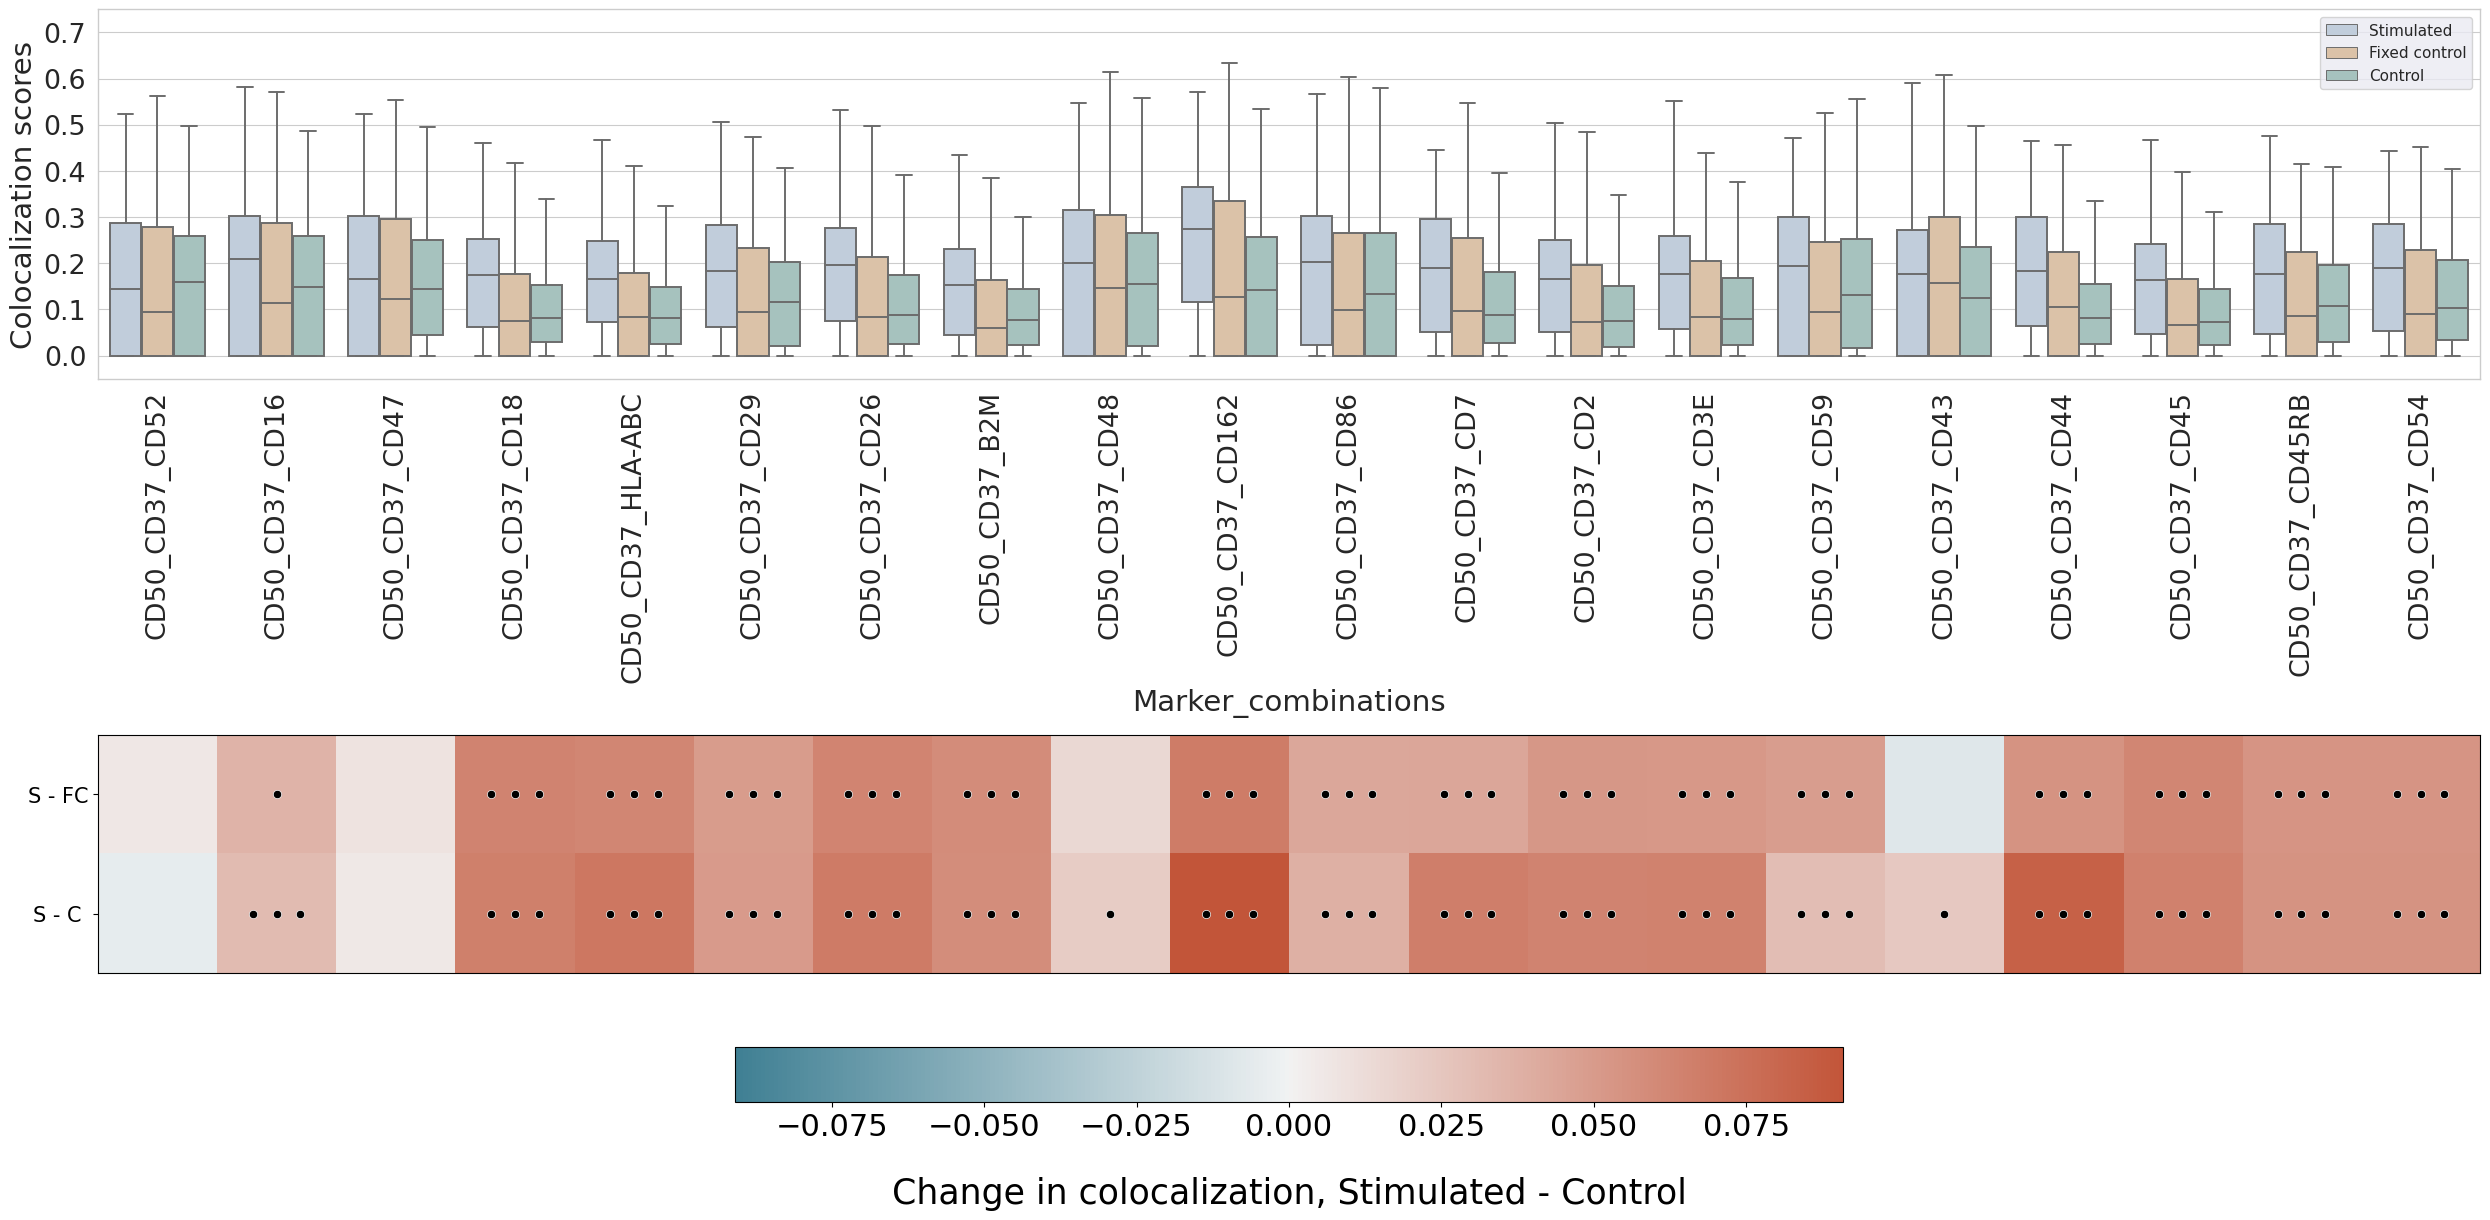

In [29]:
sns.set_theme(context="paper", style="whitegrid", font_scale=2.2)

fig = plt.figure(figsize=(25, 12))
#fig.suptitle('Differential colocalization', fontsize=22)

ax = fig.add_subplot(2, 1, 1)

sns.set(rc={'figure.figsize':(40, 15)})
#sns.stripplot(data=df, x="Marker_combinations", y="value", hue=df.index.values, dodge=True, alpha=0.3)
sns.boxplot(data=df, x="Marker_combinations", y="value", hue=df.index.values, showfliers=False, 
            width=0.8, palette=["#BDCCDF", "#E3C29F", "#A2C6C2"], linewidth=1.4)

# adjust axis
plt.xticks(rotation=90)
ax = ax.set_ylim(-0.05, 0.75)
plt.ylabel("Colocalization scores")

sns.reset_orig()
ax = fig.add_subplot(2, 1, 2)
ax.set_title('Change in colocalization, Stimulated - Control', fontsize=25, x=0.5, y=-1)

# get max values of the difference to create color bar values
max_values = max([max(np.abs(differential_1.values)), max(np.abs(differential_2.values)) ])

# test sigificane of mean shift for stimualted and fixed control sample, more dots = more sigificant
statists_S_FC = statical_test("Stimulated", "Fixed control")
sns.scatterplot(x=statists_S_FC, y=[0] * len(statists_S_FC), color="black", sizes=5)

# test sigificane of mean shift for stimualted and fixed control sample, more dots = more sigificant
statists_S_C = statical_test("Stimulated", "Control")
sns.scatterplot(x=statists_S_C, y=[1] * len(statists_S_C), color="black", sizes=5)

# add space between subplots plots
plt.subplots_adjust(hspace=20)

# plot colorbar indicading the shift of colocalization
im = plt.imshow([differential_1.values, differential_2.values], interpolation='none', aspect='equal', 
                cmap=sns.diverging_palette(220, 20, as_cmap=True), vmin=-max_values, vmax=max_values)

# add colorbar
cb = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.2)
cb.ax.tick_params(labelsize=22)

# remove labels from the axis
ax.set_xticklabels([])
ax.set_yticklabels(["S - FC", "S - C "], fontsize=15)
ax.set_xticks([])
ax.set_yticks([0, 1])

plt.tight_layout()
plt.show()
#plt.savefig("figure_paper.eps")